In [1]:
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline
from lattice_hamiltonians import *
from openfermion_hamiltonians import *
from sympy import S, symbols, printing

from compilers import * 
from utils import *

from plotting import crossover_advantage, ham_spec

Numpy 1.16 has memory leak bug  https://github.com/numpy/numpy/issues/13808
It is recommended to downgrade to numpy 1.15 or older


### Data Analysis

In [2]:
def extract(lst):
    x_lst = []
    y_lst = []
    z_lst = []
    for tup in lst:
        x, [y, z] = tup
        x_lst.append(x)
        y_lst.append(y)
        z_lst.append(z)
    return x_lst, y_lst, z_lst #gates. nb. weight

In [4]:
#Load file
filepath = os.path.join(os.path.expanduser('~'), 'Desktop', 'sim_runs', 'h4real_02-07-2023_18:55')
# reads it back
with open(filepath,"r") as f:
  file = f.read()

# decoding the JSON to dictionay
dataset = json.loads(file)
print(dataset.keys())
#print(dataset['trotter2'])
#print(dataset['is_time_imaginary'])
#print(dataset)

dict_keys(['time', 'qdtime', 'norm', 'epsilon', 'compopt', 'compopt12', 'compopt21', 'compopt22', 'qdrift', 'trotter1', 'trotter2'])


0.149023322440177


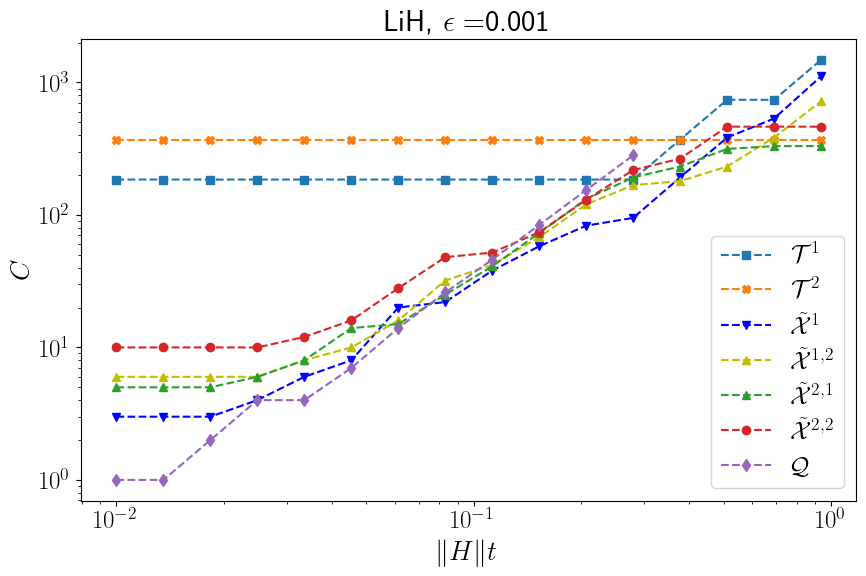

In [5]:
#plotting
plt.rcParams['text.usetex'] = True
time_series = np.array(dataset['time']) * dataset['norm']
savepath = os.path.join(os.path.expanduser('~'), 'Desktop', 'sim_runs', 'Plots', 'graph8.svg')
print(time_series[-1]/ (2*math.pi))

plt.figure(figsize = (10, 6))
plt.title(r"LiH, $\epsilon =$" + str(dataset['epsilon']), size =22)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel(r"$\|H\| t$", size =20)
plt.ylabel(r"$C$", size =20)
plt.loglog(time_series, dataset['trotter1'], "s--", label=r"$\mathcal{T}^1$")
plt.loglog(time_series, dataset['trotter2'], "X--", label=r"$\mathcal{T}^2$")
#plt.loglog(time_series, dataset['compopt'], "bv--", label=r"$\tilde{\mathcal{X}}^1$")
plt.loglog(time_series, extract(dataset['compopt'])[0], "bv--", label=r"$\tilde{\mathcal{X}}^1$")
plt.loglog(time_series, extract(dataset['compopt12'])[0], "y^--", label=r"$\tilde{\mathcal{X}}^{1,2}$")
plt.loglog(time_series, extract(dataset['compopt21'])[0], "^--", label=r"$\tilde{\mathcal{X}}^{2,1}$")
plt.loglog(time_series, extract(dataset['compopt22'])[0], "o--", label=r"$\tilde{\mathcal{X}}^{2,2}$")
#plt.loglog(time_series, dataset['compheur11_1'], "o--", label=r"$\mathcal{X}^1_{N_B = 1}$")
#plt.loglog(time_series, dataset['compheur11_5'], "p--", label=r"$\mathcal{X}^{1}_{N_B = 5}$")
#plt.loglog(time_series, dataset['compheur11_10'], "p--", label=r"$\mathcal{X}^{1}_{N_B = 10}$")
plt.loglog(time_series[:len(dataset['qdrift'])], dataset['qdrift'], "d--", label=r"$\mathcal{Q}$")
plt.legend(fontsize = 18)
#uncomment to save below
#plt.savefig(savepath, format="svg")
plt.show()

array('d', [185.0])
array('d', [85.90625])
2.1535103674063296


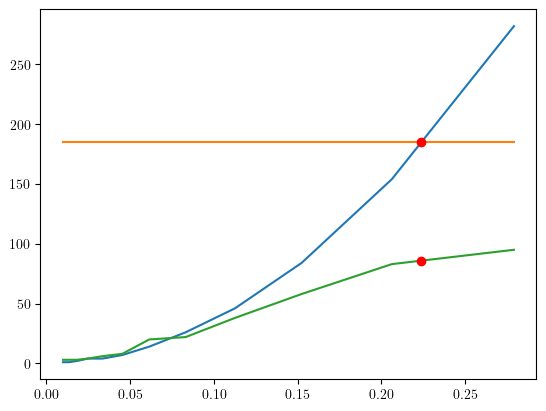

In [6]:
#crossover
#l = len(dataset['qdrift'])
l = len(dataset['qdtime'])
qdrift_data = dataset['qdrift'][:l]
trotter_data = dataset['trotter1'][:l] 
comp_data = extract(dataset['compopt'])[0][:l]
#comp_data = dataset['compopt'][:l]
adv = crossover_advantage(qd_data=qdrift_data, trot_data= trotter_data, comp_data= comp_data, times = time_series[:l])
print(adv)

In [25]:
#study the number of terms
def card_A(w_list, H_list): #returns a list of the fraction |A|/|H| where H is the set of all terms 
    a_card_t = []
    for weight in w_list:
        a_terms = 0
        for h in H_list:
            if np.linalg.norm(h, 2) >= weight:
                a_terms +=1
        a_card_t.append(a_terms)
    return (1/len(H_list)) * np.array(a_card_t)

#hamiltonian = hydrogen_chain_hamiltonian(3, 0.8)
hamiltonian = exp_loc_graph_hamiltonian(8, 1, 1)

comp_w = card_A(extract(dataset['compopt'])[2], hamiltonian)
comp22_w = card_A(extract(dataset['compop22'])[2], hamiltonian)


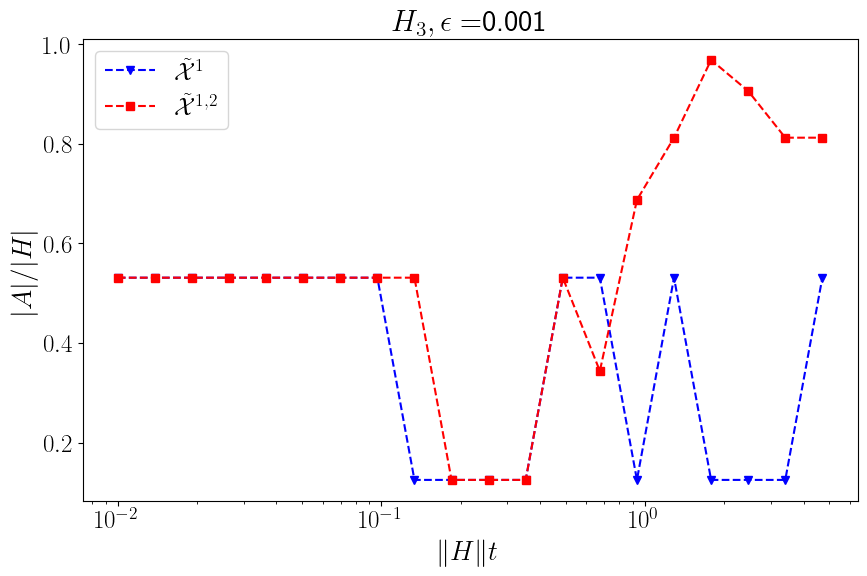

[0.53125 0.53125 0.53125 0.53125 0.53125 0.53125 0.53125 0.53125 0.125
 0.125   0.125   0.125   0.53125 0.53125 0.125   0.53125 0.125   0.125
 0.125   0.53125]
[0.53125 0.53125 0.53125 0.53125 0.53125 0.53125 0.53125 0.53125 0.53125
 0.125   0.125   0.125   0.53125 0.34375 0.6875  0.8125  0.96875 0.90625
 0.8125  0.8125 ]


In [26]:
plt.rcParams['text.usetex'] = True
time_series = np.array(dataset['time']) * dataset['norm']
savepath = os.path.join(os.path.expanduser('~'), 'Desktop', 'sim_runs', 'Plots', 'H3_w')

plt.figure(figsize = (10, 6))
plt.title(r"$ H_3, \epsilon =$" + str(dataset['epsilon']), size =22)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel(r"$\|H\| t$", size =20)
plt.ylabel(r"$|A|/|H|$", size =20, rotation=90)
plt.semilogx(time_series, comp_w, "bv--", label=r"$\tilde{\mathcal{X}}^1$")
plt.semilogx(time_series, comp22_w, "rs--", label=r"$\tilde{\mathcal{X}}^{1,2}$")
plt.legend(fontsize = 18)
#plt.savefig(savepath, format="svg")
plt.show()
print(comp_w)
print(comp22_w)

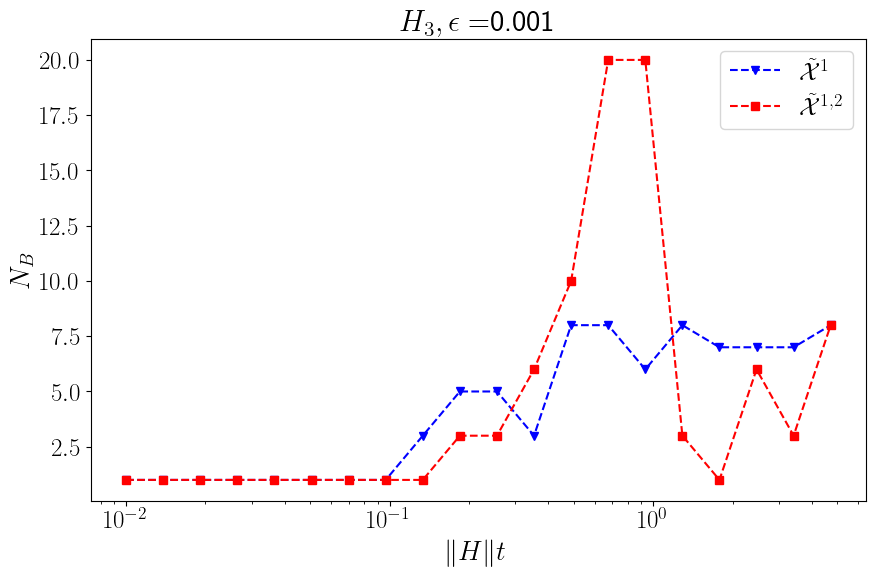

[1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 6, 10, 20, 20, 3, 1, 6, 3, 8]
[1, 1, 1, 1, 1, 1, 1, 1, 3, 5, 5, 3, 8, 8, 6, 8, 7, 7, 7, 8]


In [28]:
#study the choice of N_b

plt.rcParams['text.usetex'] = True
time_series = np.array(dataset['time']) * dataset['norm']
savepath = os.path.join(os.path.expanduser('~'), 'Desktop', 'sim_runs', 'Plots', 'H3_nb')

plt.figure(figsize = (10, 6))
plt.title(r"$H_3, \epsilon =$" + str(dataset['epsilon']), size =22)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel(r"$\|H\| t$", size =20)
plt.ylabel(r"$N_B$", size =20, rotation=90)
plt.semilogx(time_series, extract(dataset['compopt'])[1], "bv--", label=r"$\tilde{\mathcal{X}}^1$")
plt.semilogx(time_series, extract(dataset['compop22'])[1], "rs--", label=r"$\tilde{\mathcal{X}}^{1,2}$")
plt.legend(fontsize = 18)
#plt.savefig(savepath, format="svg")
plt.show()
print(extract(dataset['compop22'])[1])
print(extract(dataset['compopt'])[1])

### Local Blocks Study

In [25]:
#Load file
filepath = os.path.join(os.path.expanduser('~'), 'Desktop', 'sim_runs', 'local_heisenberg_8_28-06-2023_13:24')
# reads it back
with open(filepath,"r") as f:
  file = f.read()

# decoding the JSON to dictionay
dataset = json.loads(file)
print(dataset.keys())
#print(dataset['trotter2'])
#print(dataset['is_time_imaginary'])
#print(dataset)
print(dataset['ham_dims'])
print(dataset)

dict_keys(['partitions', 'time', 'norm', 'epsilon', 'blocks', 'block_nb', 'ham_dims', 'coupling', 'qd_times', 'trotter_block_2', 'chop_block_2', 'trotter_block_3', 'chop_block_3', 'trotter'])
[29, 256, 256]
{'partitions': ['trotter', 'chop'], 'time': [0.012499649913295774, 0.016459440688336303, 0.021673662034701682, 0.02853970769051389, 0.037580862604384015, 0.04948618428068273, 0.06516301822130113, 0.08580614984629492, 0.11298886319906565, 0.14878284633311073, 0.19591608178216532, 0.25798075548937915, 0.33970702964992316, 0.4473235446367424, 0.5890321251008144], 'norm': 8.000224061765989, 'epsilon': 1e-06, 'blocks': [2, 3], 'block_nb': [4, 1, 4], 'ham_dims': [29, 256, 256], 'coupling': 5e-05, 'qd_times': [0.012499649913295774, 0.016459440688336303, 0.021673662034701682, 0.02853970769051389, 0.037580862604384015, 0.04948618428068273, 0.06516301822130113, 0.08580614984629492, 0.11298886319906565, 0.14878284633311073, 0.19591608178216532], 'trotter_block_2': [39.0, 39.0, 39.0, 39.0, 39.0

0.75


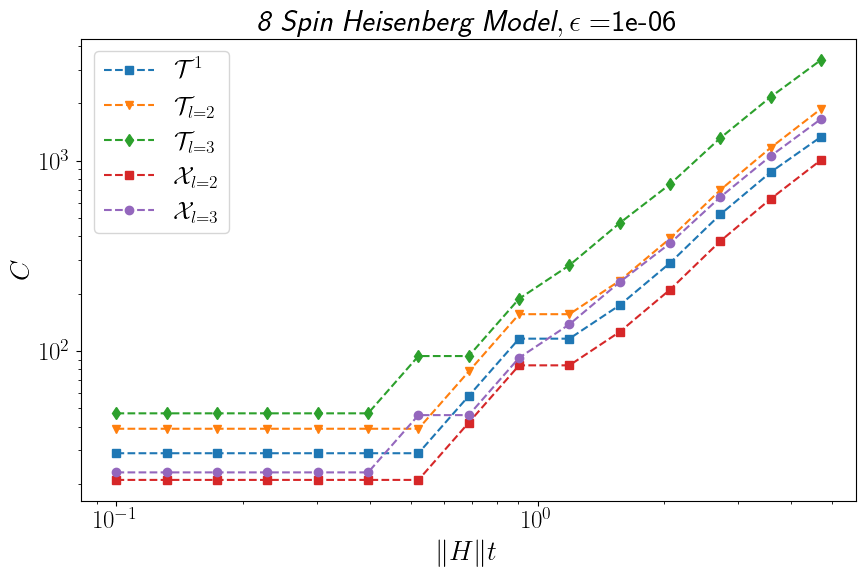

In [26]:
#block plotting
plt.rcParams['text.usetex'] = True
time_series = np.array(dataset['time']) * dataset['norm']
savepath = os.path.join(os.path.expanduser('~'), 'Desktop', 'sim_runs', 'Plots', 'local_Heisen8_')
print(time_series[-1]/ (2*math.pi))

plt.figure(figsize = (10, 6))
plt.title(r"$\textit{8 Spin Heisenberg Model}, \epsilon =$" + str(dataset['epsilon']), size =22)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel(r"$\|H\| t$", size =20)
plt.ylabel(r"$C$", size =20)
plt.loglog(time_series, dataset['trotter'], "s--", label=r"$\mathcal{T}^1$")
#plt.loglog(time_series, dataset['block 2.0'], "X--", label=r"$\mathcal{T}^2$")
plt.loglog(time_series, dataset['trotter_block_2'], "v--", label=r"$\mathcal{T}_{l = 2}$")
plt.loglog(time_series, dataset['trotter_block_3'], "d--", label=r"$\mathcal{T}_{l = 3}$")
plt.loglog(time_series, dataset['chop_block_2'], "s--", label=r"$\mathcal{X}_{l = 2}$")
plt.loglog(time_series, dataset['chop_block_3'], "o--", label=r"$\mathcal{X}_{l = 3}$")
#plt.loglog(time_series, dataset['trotter_block_4'], "x--", label=r"$l = 4$")
#plt.loglog(time_series, dataset['block 5'], "o--", label=r"$l = 5$")
plt.legend(fontsize = 18)
plt.savefig(savepath, format="svg")
plt.show()

### Dynamics

In [2]:
dim = 6
#ising = normalize_hamiltonian(ising_model(dim=dim, b_field=1.5))
ising = ising_model(dim=dim, b_field=0.1)
cooler = CompositeSim(ising, inner_order=1, nb=1, state_rand=True, use_density_matrices=True, exact_qd=True, imag_time=True, rng_seed=1) 
partition_sim(cooler, "trotter")
print(cooler.initial_state)
 
beta = np.linspace(0.00001, 1.5, 100)
populations = []
energies = []
spins = []
amplitudes = np.zeros((2**dim, len(beta)))
x_measurements = []

for b in range(len(beta)):
    state_t = cooler.simulate(time=beta[b], iterations=100)
    if cooler.use_density_matrices == True:
        #populations.append(np.real(np.diag(state_t))
        energies.append(np.real(np.trace(sum(ising) @ state_t)))
        local_spin = []
        local_x = []
        for j in range(dim):
            local_spin.append(np.real(np.trace(state_t @ initialize_operator(Z, j, dim))))
            local_x.append(np.real(np.trace(state_t @ initialize_operator(X, j, dim))))
        spins.append(local_spin)
        x_measurements.append(local_x)
    else:
        energies.append(np.real((state_t.T.conj() @ sum(ising) @ state_t).flat[0]))
        amplitudes[:, b] =  np.real(np.abs(state_t.flat[0])**2)
amplitudes = np.transpose(amplitudes)

[[ 0.02692756+0.j         -0.00964571-0.00164814j -0.00285558-0.01961837j
  ...  0.02469851-0.01306447j  0.01523956-0.02239909j
  -0.00298631-0.00650151j]
 [-0.00964571+0.00164814j  0.00355606+0.j          0.00222366+0.00685271j
  ... -0.00804761+0.00619152j -0.00408799+0.00895632j
   0.00146766+0.00214612j]
 [-0.00285558+0.01961837j  0.00222366-0.00685271j  0.01459601+0.j
  ...  0.00689907+0.01937982j  0.014703  +0.0134783j
   0.00505344-0.00148625j]
 ...
 [ 0.02469851+0.01306447j -0.00804761-0.00619152j  0.00689907-0.01937982j
  ...  0.02899248+0.j          0.02484542-0.01315111j
   0.00041523-0.00741219j]
 [ 0.01523956+0.02239909j -0.00408799-0.00895632j  0.014703  -0.0134783j
  ...  0.02484542+0.01315111j  0.02725696+0.j
   0.00371804-0.00616361j]
 [-0.00298631+0.00650151j  0.00146766-0.00214612j  0.00505344+0.00148625j
  ...  0.00041523+0.00741219j  0.00371804+0.00616361j
   0.00190094+0.j        ]]


(array([-7., -6., -5., -4., -3., -2., -1.,  0.,  1.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

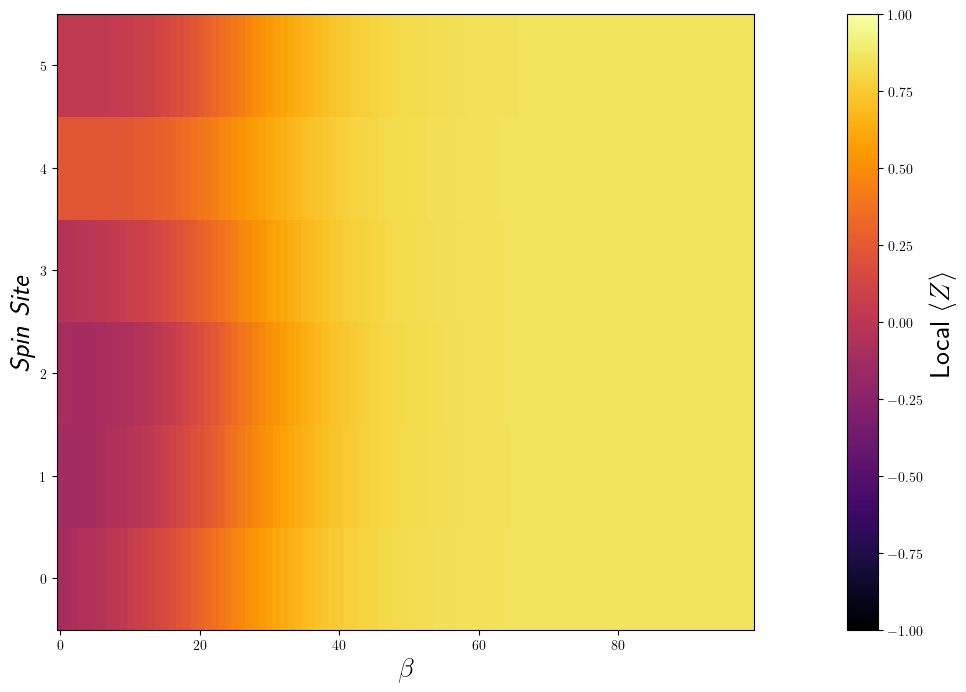

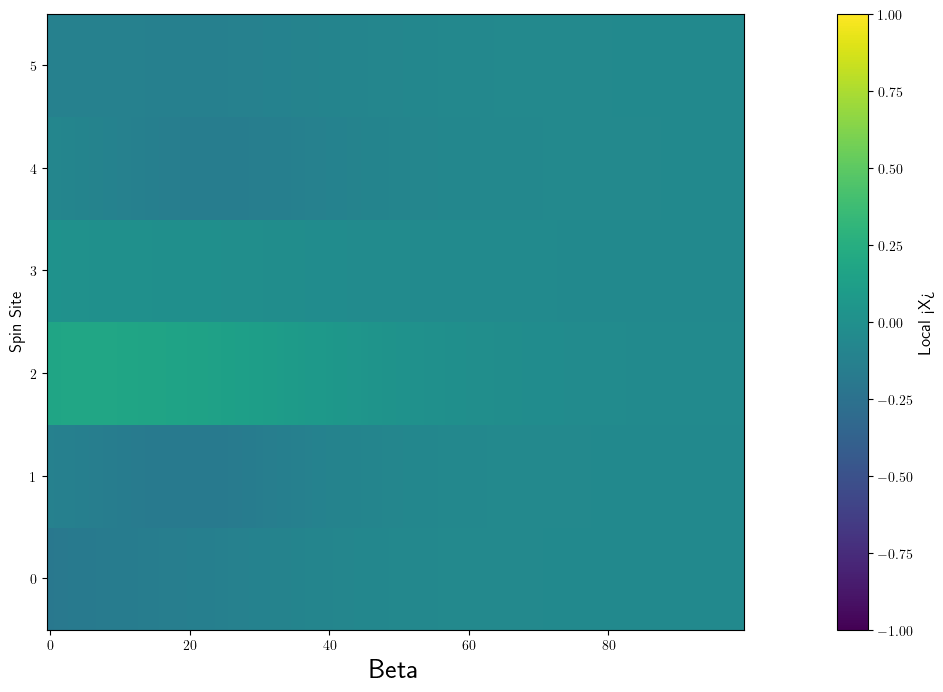

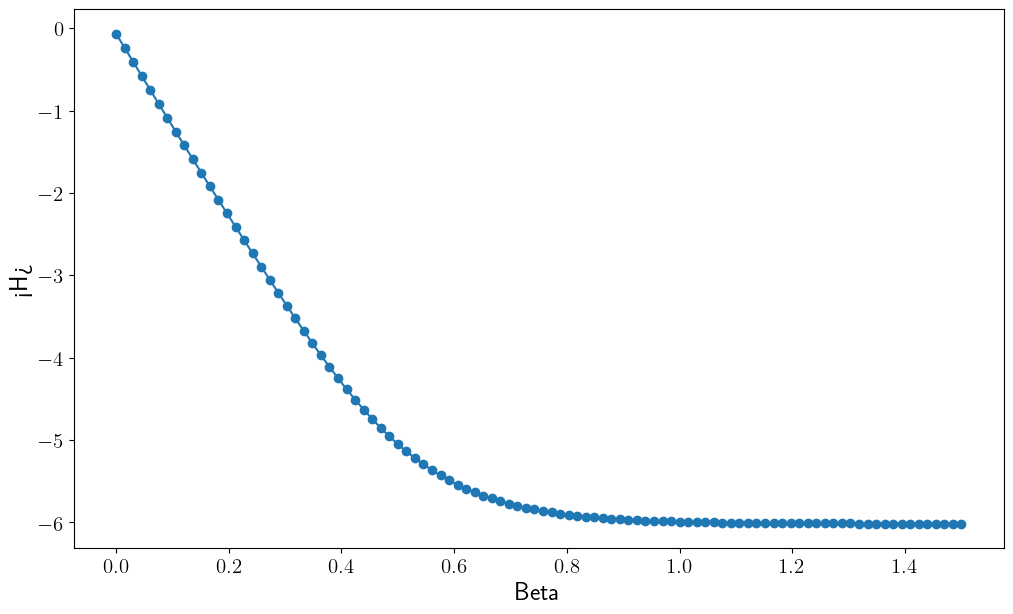

In [12]:
plt.rcParams['text.usetex'] = True
plt.figure(figsize = (12,8))
#plt.ylim(-60,60) #limits the range the plot shows
plt.xlabel(r'$\beta$', size = 20)
plt.ylabel(r'\textit{Spin Site}', size = 20)
plt.imshow(np.transpose(spins), origin = 'lower', aspect = 'auto', 
           cmap = 'inferno', vmax=1, vmin=-1, interpolation = 'none') 
# vmax alters the sensitivity of the colour plot, so increase for large particle numbers
cbar = plt.colorbar(pad = 0.1) #pad chooses the distance of the colour bar from the plot
cbar.set_label(r'Local $\langle Z \rangle$',size=20) 

plt.figure(figsize = (12,8))
#plt.ylim(-60,60) #limits the range the plot shows
plt.xlabel('Beta', size = 20)
plt.ylabel('Spin Site', size = 12)
plt.imshow(np.transpose(x_measurements), origin = 'lower', aspect = 'auto', 
             vmax=1, vmin=-1, interpolation = 'none') 
# vmax alters the sensitivity of the colour plot, so increase for large particle numbers
cbar = plt.colorbar(pad = 0.1) #pad chooses the distance of the colour bar from the plot
cbar.set_label('Local <X>',size=12)

plt.figure(figsize = (12, 7))
plt.plot(beta, energies, 'o-') 
plt.xlabel('Beta', size = 18)
plt.ylabel('<H>', size = 18)
plt.xticks(fontsize=15, rotation=0)
plt.yticks(fontsize=15)

### Norm Distributions

In [ ]:
jellium_hamiltonian_list=jellium_hamiltonian(dimensions=1, length=4, spinless=True)
jellium_hamiltonian_list = normalize_hamiltonian(jellium_hamiltonian_list)
hydrogen_ham = hydrogen_chain_hamiltonian(chain_length=2, bond_length=0.8)
hydrogen_ham = normalize_hamiltonian(hydrogen_ham)
#ham_spec(jellium_hamiltonian_list, q=85, y_line=0.002)
graph = normalize_hamiltonian(exp_distr_heisenberg_hamiltonian(3,5,1,False))
LiH = normalize_hamiltonian(LiH_hamiltonian())
ham_spec(LiH, q=50, y_line=0.4)
print(graph.shape)

### Error Scaling

In [4]:
heisen = (exp_distr_heisenberg_hamiltonian(7, b_field=5, rng_seed=1, b_rand=False))
#heisen = exp_loc_graph_hamiltonian(7, 1, 1)

sim = CompositeSim(heisen, nb=1, inner_order=1, state_rand=True, exact_qd=True, use_density_matrices=True, imag_time=False)
partition_sim(sim, "trotter")

tstart = 0.005
tfinal = 2.5
tsteps = 300
times = np.geomspace(tstart, tfinal, tsteps)

#print(multi_infidelity_sample(sim, 1, exact_time_evolution_density(sim.unparsed_hamiltonian, 1, sim.initial_state), 40, 20))
epsilon_data=[]
for t in times:
    #density matrices
    epsilon_data.append(sim_trace_distance(sim, time=t, iterations=6, nb=1))
    #epsilon_data.append(infidelity(sim.simulate(t, iterations=15), exact_imaginary_channel(poli, t, sim.initial_state)))

    #imaginary time class
    #epsilon_data.append(i_sim.trace_dist(t, samples=1))

    #for vectors
    #exact_state = linalg.expm(-1 * sum(poli) * t) @ sim.initial_state
    #epsilon_data.append(infidelity(sim.simulate(t, iterations=1), exact_state / np.linalg.norm(exact_state, ord=2)))
#print(epsilon_data)
print('the trace is:')
print(np.trace(sim.final_state))


NameError: name 'heisenberg_hamiltonian' is not defined

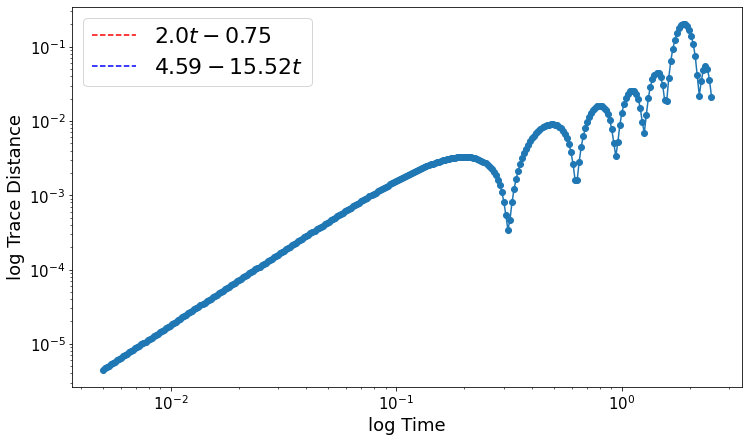

In [ ]:
data = np.log10(epsilon_data)
log_times = np.log10(times)
plt.figure(figsize = (12, 7))
plt.loglog(times, epsilon_data, 'o-') 
plt.xlabel('log Time', size = 18)
plt.ylabel('log Trace Distance', size = 18)
plt.xticks(fontsize=15, rotation=0)
plt.yticks(fontsize=15)

start_fit_points= 1 #declare the starting point to fit in the data
end_fit_points = 5

p = np.polyfit(log_times[start_fit_points: end_fit_points], data[start_fit_points: end_fit_points], 1)
f = np.poly1d(p)

t_new = np.linspace(log_times[start_fit_points], log_times[end_fit_points], 50)
y_new = f(t_new)

data = symbols("t")
poly = sum(S("{:6.2f}".format(v))*data**i for i, v in enumerate(p[::-1]))
eq_latex = printing.latex(poly)
plt.plot(t_new, y_new, 'r--', label="${}$".format(eq_latex))
plt.legend(fontsize= 22)

data = np.log10(epsilon_data)
start_fit_points1= -3 #declare the starting point to fit in the data
end_fit_points1 = -1
p1 = np.polyfit(log_times[start_fit_points1: end_fit_points1], data[start_fit_points1: end_fit_points1], 1)
f1 = np.poly1d(p1)

t_new1 = np.linspace(log_times[start_fit_points1], log_times[end_fit_points1], 50)
y_new1 = f1(t_new1)

data = symbols("t")
poly1 = sum(S("{:6.2f}".format(v))*data**i for i, v in enumerate(p1[::-1]))
eq_latex1 = printing.latex(poly1)

plt.plot(t_new1, y_new1, 'b--', label="${}$".format(eq_latex1))
plt.legend(fontsize= 22)
plt.show()

In [ ]:
graph_hamiltonian_list = graph_hamiltonian(6, 1, 1)
graph_hamiltonian_list = normalize_hamiltonian(graph_hamiltonian_list)
print(graph_hamiltonian_list.shape)
heisenberg_hamiltonian_list = exp_distr_heisenberg_hamiltonian(6, 5, rng_seed=1, b_rand=False)
local_hamiltonian_list = hamiltonian_localizer_1d(heisenberg_hamiltonian_list, 2)
print(local_hamiltonian_list[0].shape)

sim = CompositeSim(graph_hamiltonian_list, inner_order=2, outer_order=1, nb=1, state_rand=True, exact_qd=False, use_density_matrices=False, imag_time=False)
partition_sim(sim, "trotter", chop_threshold=0.005)
print(len(sim.trotter_norms),len(sim.qdrift_norms))

#local_sim = LRsim(heisenberg_hamiltonian_list[0], local_hamiltonian_list, inner_order=2, nb=[1,1,1], state_rand = True)
#local_partition(local_sim, "chop", weights=[0.01, 0.01, 0.01]) ###need to normalize the list of spectral norms
#print("optimal gate: " +str(local_sim.gate_count))
#print(local_sim.nb)

#print(len(local_hamiltonian_list[0]))
#print(len(local_hamiltonian_list[1]))
#print(len(local_hamiltonian_list[2]))

tstart = 0.5
tfinal = 1
tsteps = 20
times = np.geomspace(tstart, tfinal, tsteps)
#print(multi_infidelity_sample(sim, 1, exact_time_evolution_density(sim.unparsed_hamiltonian, 1, sim.initial_state), 40, 20))
epsilon_data=[]
for t in times:
    #epsilon_data.append(sim_trace_distance(sim, time=t, iterations=1, nb=1))
    #inf_list, _ = zip(*multi_infidelity_sample(sim, t, exact_imaginary_channel(sim.unparsed_hamiltonian, t, sim.initial_state), iterations=1, nbsamples=1, mc_saFiguresmples=1))
    inf_list, _ = zip(*multi_infidelity_sample(sim, t, exact_time_evolution(sim, t), iterations=1, nbsamples=1, mc_samples=1))
    epsilon_data.append(statistics.mean(inf_list))
#exact_cost(sim, time = 0.005, nb=1, epsilon=0.001) #should set the gate count to zero or refresh them somewhere 

### Sampling Performance

In [ ]:
iterations = 1
times = np.geomspace(0.01, 0.5, 50)

first_order_trott_sim = CompositeSim(hamiltonian_list=hamiltonian_list, inner_order=1)
partition_sim(first_order_trott_sim, "trotter")

second_order_trott_sim = CompositeSim(hamiltonian_list=hamiltonian_list, inner_order = 2)
partition_sim(second_order_trott_sim, "trotter")

qdrift_sim = CompositeSim(hamiltonian_list=hamiltonian_list)
partition_sim(qdrift_sim, "qdrift")

comp_sim = CompositeSim(hamiltonian_list=hamiltonian_list)

def test_performance(
        simulator,
        t_start=1e-3,
        t_end=1e-1,
        t_steps=50,
        num_state_samples=5,
        partitions=["first_order_trotter", "qdrift"],
        performance="infidelity",
        infidelity_threshold=0.05
    ):
    times = np.geomspace(t_start, t_end, t_steps)
    results = dict()
    for partition in partitions:
        vals = []
        partition_sim(simulator, partition_type=partition)
        simulator.print_partition()
        heuristic = -1
        for t in times:
            val = 0
            for _ in range(num_state_samples):
                simulator.randomize_initial_state()
                if performance == "infidelity":
                    inf_temp, _ = single_infidelity_sample(simulator, t)
                    val += inf_temp
                elif performance == "gate_cost":
                    cost, iters = find_optimal_cost(simulator, t, infidelity_threshold, heuristic=heuristic)
                    heuristic = iters
                    val += cost

            vals.append(val / num_state_samples)
        results[partition] = vals
    results["times"] = times
    for partition, vals in results.items():
        if partition != "times":
            plt.loglog("times", partition, data=results, label=partition)
    plt.legend()
    plt.show()
    

test_performance(comp_sim)
test_performance(comp_sim,t_start=1e-6, t_end=1e-1, performance="gate_cost")